In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import lsim, butter, lfilter
from scipy.integrate import solve_ivp
import cvxpy as cp
import opentorsion as ot

# Three degree-of-freedom drivetrain

A 3-DOF drivetrain is modelled using the [openTorsion](https://github.com/Aalto-Arotor/openTorsion) tool. The modelling method used is the shaft-line FEM presented in [Dynamics of Rotating Machines](https://www.cambridge.org/core/books/dynamics-of-rotating-machines/A39F69AD446EC361364E97BA307CBC35).

The mass and stiffness matrices are $$ \textbf{M} = \begin{bmatrix} J_1 & 0 & 0 \\ 0 & J_2 & 0 \\ 0 & 0 & J_3 \\ \end{bmatrix} \qquad \textbf{K} = \begin{bmatrix} k_1 & -k_1 & 0 \\ -k_1 & k_1 + k_2 & -k_2 \\ 0 & -k_2 & k_2 \\ \end{bmatrix} $$ respectively.

In [2]:
def drivetrain_3dof():
    """
    Mechanical drivetrain as an openTorsion assembly instance.

    Returns:
    assembly: opentorsion assembly instance
        A 3-DOF mechanical drivetrain modeled as lumped masses and flexible shafts
        (lumped mass - shaft - lumped mass - shaft - lumped mass).
    """
    # Disk 1 inertia
    J1 = 0.8
    # Disk 2 inertia
    J2 = 0.5
    # Disk 3 inertia
    J3 = 0.7
    # Shaft 1 stiffness
    k1 = 1.5e4
    # Shaft 2 stiffness
    k2 = 1e4

    disks, shafts = [], []
    shafts.append(ot.Shaft(0, 1, None, None, k=k1, I=0))
    shafts.append(ot.Shaft(1, 2, None, None, k=k2, I=0))
    disks.append(ot.Disk(0, I=J1))
    disks.append(ot.Disk(1, I=J2))
    disks.append(ot.Disk(2, I=J3))
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()

    return assembly

In torsional forced response analysis, a modal damping matrix can be used. Methods for calculating the modal damping matrix are presented for example in [Introduction to Dynamics of Rotor-Bearing Systems](https://www.amazon.com/Introduction-Dynamics-Rotor-Bearing-Systems-Jeng/dp/1412051908) (or openTorsion source code).

The undamped eigenfrequencies and eigenmodes are solved from the eigenvalue problem
$\begin{equation}
    \left(\textbf{K} - \omega_i^2 \textbf{M}\right)\varphi_i = 0
\end{equation}$,
where $\omega_i$ and $\varphi_i$ are the eigenfrequency and eigenmode of the $i^{\text{th}}$ mode respectively. The eigenmodes form the modal matrix $\boldsymbol{\Phi} = [\varphi_1 \varphi_2 \varphi_3]$.
The damping matrix $\textbf{C}$ used in torsional forced response analysis is calculated as follows:
$$\begin{equation}
    \begin{aligned}
        \hat{\textbf{M}} &= \boldsymbol{\Phi}^{\text{T}} \textbf{M} \boldsymbol{\Phi} \\
        \hat{\textbf{C}} &= \text{diag}(2 \xi_i \omega_i) \cdot \hat{\textbf{M}} \\
        \textbf{C} &= \boldsymbol{\Phi}^{-\text{T}} \hat{\textbf{C}} \boldsymbol{\Phi}^{-1}
    \end{aligned}
\end{equation}$$
where $\xi_i$ is some factor of the critical damping ratio.

OpenTorsion builds the system matrices (works for geared and branched systems also). The state-space model is created using the system matrices. The state-space model is
$$ \dot{\textbf{x}} = \textbf{A}\textbf{x} + \textbf{B}\textbf{u} $$ where $$ \textbf{A} = \begin{bmatrix} \boldsymbol{0} & \textbf{I} \\ -\textbf{M}^{-1}\textbf{K} & -\textbf{M}^{-1}\textbf{C} \end{bmatrix} \quad \textbf{B} = \begin{bmatrix} \boldsymbol{0} \\ \textbf{M}^{-1} \end{bmatrix} \quad \textbf{x} = \begin{bmatrix} \boldsymbol{\theta} \\ \boldsymbol{\dot{\theta}} \end{bmatrix} \quad \textbf{u} = \begin{bmatrix} \boldsymbol{0} \\ \textbf{T} \end{bmatrix}. $$

In [3]:
def state_matrices(assembly):
    """
    Create state-space matrices A and B of an openTorsion assembly.

    Parameters:
    assembly : openTorsion assembly instance
        Mechanical drivetrain model.

    Returns:
    A : numpy.ndarray
        The state matrix
    B : numpy.ndarray
        The input matrix
    """
    M, K = assembly.M(), assembly.K()  # Mass and stiffness matrices
    C = assembly.C_modal(M, K, xi=0.02)  # Modal damping matrix, modal damping coefficient 0.02 used
    Z = np.zeros(M.shape)
    I = np.eye(M.shape[0])
    M_inv = LA.inv(M)

    A = np.vstack([np.hstack([Z, I]), np.hstack([-M_inv @ K, -M_inv @ C])])

    B = np.vstack([Z, M_inv])

    return A, B

Response of the system when 100 Nm is applied at node 3 for ~2 seconds.

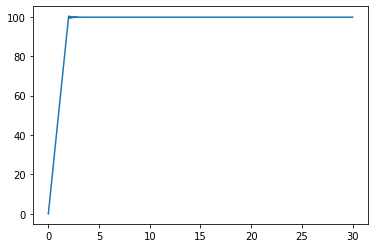

In [4]:
assembly = drivetrain_3dof()
A, B = state_matrices(assembly)
C = np.eye(B.shape[0])
D = np.zeros(B.shape)

t = np.arange(0, 30.01, 0.01)

# impulse applied at node 3
u = np.zeros((len(t), 3))
u[0:200,-1] = 100

tout, yout, xout = lsim((A, B, C, D), u, t)

# plot speed at node 1
plt.plot(tout, yout[:,3])
plt.show()

# Kalman filter

In [5]:
class PredictionDerivative:
    """
    This class is used in the calculation of predicted state in the conventional Kalman filter algorithm.
    """

    def __init__(self, A, B, u0):
        """
        Initialize the state matrices and the input matrix.

        Parameters:
        A : numpy.ndarray
            The state matrix
        B : numpy.ndarray
            The input matrix
        u0 : float
            The initial load on the drivetrain
        """
        self.A = A
        self.B = B
        self.u = u0

    def update_load(self, u):
        """
        Update the load on the drivetrain.

        Parameters:
        u : float
            The updated load on the drivetrain
        """
        self.u = u

    def f(self, t, x):
        """
        State derivative function used by `scipy.integrate.solve_ivp`
        (see `conventional_kalman_filter` function).

        Parameters:
        t : float
            The time step
        x : numpy.ndarray
            The state vector

        Returns:
        numpy.ndarray
            The derivative of the state vector
        """
        return self.A @ x + self.B @ self.u

A conventional Kalman filter algorithm.

In [6]:
def conventional_kalman_filter(A, B, C, Q, R, time, Y, load, m0, P0):
    """
    A conventional Kalman filter.

    Parameters:
    A : numpy.ndarray
        The state matrix
    B : numpy.ndarray
        The input matrix
    C : numpy.ndarray
        The observation matrix
    Q : numpy.ndarray
        The process covariance matrix
    R : numpy.ndarray
        The measurement covariance matrix
    time : numpy.ndarray
        Measurement timesteps
    Y : numpy.ndarray
        Measurements
    load : numpy.ndarray
        Excitation data
    m0 : numpy.ndarray
        Initial state guess
    P0 : numpy.ndarray
        Initial estimate covariance guess

    Returns:
    x : numpy.ndarray
        The Kalman filter estimated states
    """
    T = Y.shape[1]
    nx = m0.shape[0]  # dimension of x
    x = np.zeros((nx, T))
    x[:, 0] = m0
    P = P0
    I = np.eye(P0.shape[0])
    predd = PredictionDerivative(A, B, load[:, 0])
    for n in range(T-1):
        # Prediction
        dt = time[n + 1] - time[n]
        x_hat = x[:, n]
        u_hat = load[:, n]
        predd.update_load(u_hat)
        sol = solve_ivp(predd.f, (time[n], time[n] + dt), x_hat, dense_output=True)
        x_ = sol.y[:, -1]
        P_ = A @ P @ A.T + Q
        # Update
        S = C @ P_ @ C.T + R
        K = P_ @ C.T @ LA.inv(S)
        P = (I - K @ C) @ P_
        y = Y[:, n]
        x[:, n+1] = x_ + K @ (y - C @ x_)

    return x

Gaussian white noise is added to the measurements. Speed measurements from nodes 1 and 2 are used in the Kalman filter. The Kalman filter algorithm is run and estimated speed is plotted.

In [7]:
R_ = 1e-5*np.eye(C.shape[0]) # measurement covariance, shape (n_sensors, n_sensors)
Q_ = 1e-2*np.diag(np.array([0, 0, 0, 1, 1, 1])) # process (speed) covariance, shape (n_states, n_states)

# add gaussian white noise to the measurement (measurement and process noise)
r = np.random.multivariate_normal(np.zeros(R_.shape[0]), R_, tout.shape[0])
q = np.random.multivariate_normal(np.zeros(Q_.shape[0]), Q_, tout.shape[0])

yout_noise = (yout + r + q).T # shape (n_states, n_timesteps)
    
meas = np.vstack([yout_noise[3,:], yout_noise[4,:]]) # use speed measurements at node 1 and 2

In [8]:
# C, Q and R matrices redefined
C = np.array([[0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0]])
R = 1e-4*np.eye(C.shape[0])
Q = 1e-2*np.diag(np.array([0, 0, 0, 1, 1, 1])) # process (speed) covariance, shape (n_states, n_states)

    
m0 = 0*np.copy(yout[0,:]) # initial state guess
P0 = 1e-2*np.eye(A.shape[0]) # randomly chosen estimate covariance
x_kalman = conventional_kalman_filter(A, B, C, Q, R, t, meas, u.T, m0, P0)

Compare estimate to measurement at node 3.

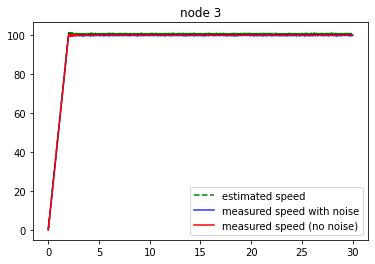

In [9]:
plt.plot(tout, x_kalman[-1,:], label="estimated speed", linestyle='--', color='green')
plt.plot(tout, yout_noise[-1,:], label="measured speed with noise", alpha=0.8, color='b')
plt.plot(tout, yout[:,-1], label="measured speed (no noise)", color='r')
plt.title("node 3")
plt.legend()

plt.show()

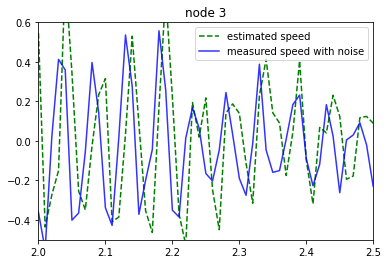

In [10]:
# zoomed in version of the same plot
start = int(2/0.01)
tout_mod = tout[start:]
x_kalman_mod = x_kalman[-1,:][start:]
yout_noise_mod = yout_noise[-1,:][start:]
x_kalman_mod -= np.mean(x_kalman_mod)
yout_noise_mod -= np.mean(yout_noise_mod)
plt.plot(tout_mod, x_kalman_mod, label="estimated speed", linestyle='--', color='green')
plt.plot(tout_mod, yout_noise_mod, label="measured speed with noise", alpha=0.8, color='b')
#plt.plot(tout, yout[:,-1], label="measured speed (no noise)", color='r')
plt.title("node 3")
#plt.ylim(99, 102)
plt.ylim(-0.5, 0.6)
plt.xlim(2, 2.5)
plt.legend()

plt.show()

# Convex optimization methods

In [19]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    O = C
    for k in range(1, n):
        O = np.vstack((O, C @ np.linalg.matrix_power(A, k)))

    return O

In [20]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    # first column
    gamma_column_first = np.zeros(B.shape)
    for k in range(1, n):
        gamma_column_first = np.vstack((gamma_column_first, C @ np.linalg.matrix_power(A, k) @ B))

    # build complete matrix
    gamma = gamma_column_first
    current_col = 1
    for s in range(1, n):
        gamma_rows = np.zeros(B.shape)
        current_row = current_col
        for k in range(1, n):
            if current_row > 0:
                row_val = np.zeros(B.shape)
                current_row -= 1
            else:
                row_val = C @ np.linalg.matrix_power(A, k-current_col) @ B
            gamma_rows = np.vstack((gamma_rows, row_val))

        gamma = np.hstack((gamma, gamma_rows))
        current_col += 1

    return gamma

In [21]:
def L(input_shape):
    '''
    The regularization matrix L. Currently an identity matrix with diagonal of length n.

    Parameters:

    meas_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    L = np.eye(input_shape)

    return L

In [23]:
def convex_optimization_problem(meas, O, gamma, L, lam=1):
    '''
    Convex optimization methods using the cvxpy library.
    '''
    d = cp.Variable((gamma.shape[1], 1), complex=False)
    x = np.array(meas[:6,0]).reshape(6, 1) # first measurement used as the initial state
    objective = cp.Minimize(cp.sum_squares(meas - O @ x - gamma @ d) + lam * cp.pnorm(L @ d, 1))
    prob = cp.Problem(objective)
    prob.solve(solver=cp.CVXOPT)

    return prob.value